<a href="https://colab.research.google.com/github/enochs1004/Enochs_Jay/blob/main/aSSIST_Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***퇴사자 예측 분류 모델과 긍부정 감성 분석 모델을 활용한 기업 지속가능가치평가에 대한 연구***

    Resources : Link - https://www.kaggle.com/code/valbauman/hr-analytics-predicting-quitters/notebook

퇴사자 데이터를 활용하여 신경망 모델을 통해 학습한 퇴사자 예측 모델 생성

In [ ]:
# 이론 배경 
# 모델 설계 및 검증 
# 다양한 분류기를 통한 퍼포먼스 향상 
# 결정나무 예측의 확률을 알 수 있나


# 예측기를 결정트리가 아닌 다양화 시켜야 한다. 
# 인공신경망과 결정트리 비교를 통한 모델 효율성 비교 탐구 

### ***train EDA & PCA***

    Original Column: city / city_development_index / gender / relevent_experience / enrolled_university / education_level / major_discipline / experience / company_size / last_new_job / training_hours

    EDA: relevent_experience / experience / last_new_job / gender / education_level / enrolled_university / company_size

In [ ]:
# Load Train set
import pandas as pd
from google.colab import drive

drive.mount("/content/drive")
hr_train = pd.read_csv("/content/drive/My Drive/Study with me/Dataset/aug_train.csv")
hr_train = hr_train.set_index("enrollee_id")
hr_train.head()

Mounted at /content/drive


,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
enrollee_id,,,,,,,,,,,,,
8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [ ]:
# train EDA
import numpy as np
import pandas as pd

# 데이터 분류 
  # relevent_experience: 없을 경우 0 있을 경우 1 
hr_train.replace({"relevent_experience":"No relevent experience"}, 0, inplace=True)
hr_train.replace({"relevent_experience":"Has relevent experience"}, 1, inplace=True)
hr_train["relevent_experience"] = hr_train["relevent_experience"].astype(int)

  # experience column 카테고리별 정렬 
hr_train["experience"].replace(">20", 20, inplace=True)
hr_train["experience"].replace("<1", 1, inplace=True)
hr_train["experience"] = hr_train["experience"].fillna(0)
hr_train["experience"] = hr_train["experience"].astype(int)

  # last_new_job 카테고리별 정렬
hr_train["last_new_job"].loc[hr_train["last_new_job"]==">4"] = 4
hr_train["last_new_job"].loc[hr_train["last_new_job"]=="never"] = 0
hr_train["last_new_job"] = hr_train["last_new_job"].fillna(0)
hr_train["last_new_job"] = hr_train["last_new_job"].astype(int)

# dummy instances
  # Gender, education_level, enrolled_univerisity, company_size Encoder 함수 작성
from sklearn.preprocessing import OrdinalEncoder 

def ord_encode(data, col_name, inst):
  data[col_name] = OrdinalEncoder(categories=[inst], dtype=int).fit_transform(data[col_name].values.reshape(-1, 1)) # reshpae(-1, 1): 모든 컬럼 하나의 컬럼으로 정렬
  return data

  # gender 카테고리별 정렬
hr_train["gender"] = hr_train["gender"].fillna("Other")
hr_train = ord_encode(hr_train, "gender", ["Male", "Female", "Other"])

  # education_level 카테고리별 정렬
hr_train["education_level"] = hr_train["education_level"].fillna("Unknown")
hr_train = ord_encode(hr_train, "education_level", ["Primary School", "High School", "Graduate", "Masters", "Phd", "Unknown"])

  # enrolled_university 카테고리별 정렬
hr_train["enrolled_university"] = hr_train["enrolled_university"].fillna("no_enrollment")
hr_train = ord_encode(hr_train, "enrolled_university", ["no_enrollment", "Part time course", "Full time course"])

  # company_size 카테고리별 정렬
hr_train["company_size"] = hr_train["company_size"].fillna("<10") 
hr_train = ord_encode(hr_train, "company_size", ["<10", "10/49", "50-99", "100-500", "500-999", "1000-4999", "5000-9999", "10000+"])
  
  # major_discipline 카테고리별 정렬
hr_train["major_discipline"] = hr_train["major_discipline"].fillna("No Major")
hr_train = ord_encode(hr_train, "major_discipline", ["No Major", "STEM", "Business Degree", "Humanities", "Arts", "Other"])

hr_train.head(20)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
enrollee_id,,,,,,,,,,,,,
8949,city_103,0.920,0,1,0,2,1,20,0,NaN,1,36,1.0
29725,city_40,0.776,0,0,0,2,1,15,2,Pvt Ltd,4,47,0.0
11561,city_21,0.624,2,0,2,2,1,5,0,NaN,0,83,0.0
33241,city_115,0.789,2,0,0,2,2,1,0,Pvt Ltd,0,52,1.0
666,city_162,0.767,0,1,0,3,1,20,2,Funded Startup,4,8,0.0
21651,city_176,0.764,2,1,1,2,1,11,0,NaN,1,24,1.0
28806,city_160,0.920,0,1,0,1,0,5,2,Funded Startup,1,24,0.0
402,city_46,0.762,0,1,0,2,1,13,0,Pvt Ltd,4,18,1.0
27107,city_103,0.920,0,1,0,2,1,7,2,Pvt Ltd,1,46,1.0


In [ ]:
# X Drop 
hr_train.drop(["city", "company_type"], axis=1, inplace=True)
hr_train.head(10)

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,last_new_job,training_hours,target
enrollee_id,,,,,,,,,,,
8949,0.920,0,1,0,2,1,20,0,1,36,1.0
29725,0.776,0,0,0,2,1,15,2,4,47,0.0
11561,0.624,2,0,2,2,1,5,0,0,83,0.0
33241,0.789,2,0,0,2,2,1,0,0,52,1.0
666,0.767,0,1,0,3,1,20,2,4,8,0.0
21651,0.764,2,1,1,2,1,11,0,1,24,1.0
28806,0.920,0,1,0,1,0,5,2,1,24,0.0
402,0.762,0,1,0,2,1,13,0,4,18,1.0
27107,0.920,0,1,0,2,1,7,2,1,46,1.0


In [ ]:
# X, y 데이터 설정 및 validation set 분리 
X_train = hr_train.drop(["target"], axis=1)
y_train = hr_train["target"]

X_valid = X_train[-500:]
y_valid = y_train[-500:]

print(X_train.shape, y_train.shape)

(19158, 10) (19158,)


In [ ]:
X_valid.shape
y_valid.shape

(500,)

### ***RandomForestClassifier***

In [ ]:
# Randomforest Modeling & mse check
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

def get_mse(n_estimators, max_leaf_nodes, X_train, X_valid, y_train, y_valid):
  model = RandomForestClassifier(n_estimators=n_estimators, max_leaf_nodes=max_leaf_nodes, random_state=623, n_jobs=-1)
  model.fit(X_train, y_train)
  preds_val = model.predict(X_valid)
  mse = mean_squared_error(y_valid, preds_val, squared=False)
  mse = print("mean_squared_error: {}" .format(mse))
  accuracy = print(model.__class__.__name__, accuracy_score(y_valid, preds_val))
  return(accuracy, mse)

n_estimators = [100, 1000, 3000, 5000]
max_leaf_nodes = [50, 100, 150, 250]

for n_estimators, max_leaf_nodes in zip(n_estimators, max_leaf_nodes):
  my_mse = get_mse(n_estimators, max_leaf_nodes, X_train, X_valid, y_train, y_valid)
  print("n_estimators: {}, max_leaf_nodes: {}" .format(n_estimators, max_leaf_nodes, my_mse))
  

mean_squared_error: 0.4626013402488151
RandomForestClassifier 0.786
n_estimators: 100, max_leaf_nodes: 50
mean_squared_error: 0.44944410108488464
RandomForestClassifier 0.798
n_estimators: 1000, max_leaf_nodes: 100
mean_squared_error: 0.4427188724235731
RandomForestClassifier 0.804
n_estimators: 3000, max_leaf_nodes: 150
mean_squared_error: 0.4219004621945797
RandomForestClassifier 0.822
n_estimators: 5000, max_leaf_nodes: 250


In [ ]:
# High Accuracy Model select 
rnd_clf = get_mse(10000, 250, X_train, X_valid, y_train, y_valid)
print(rnd_clf)

mean_squared_error: 0.4219004621945797
RandomForestClassifier 0.822
(None, None)


### ***Boosting***

In [ ]:
# Ada Boosting 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

  # n_estimators: 사용할 Decisiontree의 수
ada_clf = AdaBoostClassifier(RandomForestClassifier(max_depth=2), n_estimators=30, algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train, y_train) 
y_pred_ada = ada_clf.predict(X_valid)

In [ ]:
# Ada Boosting RandomForestClassifier Accuracy_score
ada_mse = mean_squared_error(y_valid, y_pred_ada, squared=False)
ada_mse = print("mean_squared_error: {}" .format(ada_mse))

print(ada_mse)
print(ada_clf.__class__.__name__, accuracy_score(y_valid, y_pred_ada))

In [ ]:
# Ada Boosting 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=5000,algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train, y_train)
y_pred_ada = ada_clf.predict(X_valid)

print(ada_mse)
print(ada_clf.__class__.__name__, accuracy_score(y_valid, y_pred_ada))

None
AdaBoostClassifier 0.808


Text(0.5, 0, 'RandomForest Feature Importances')

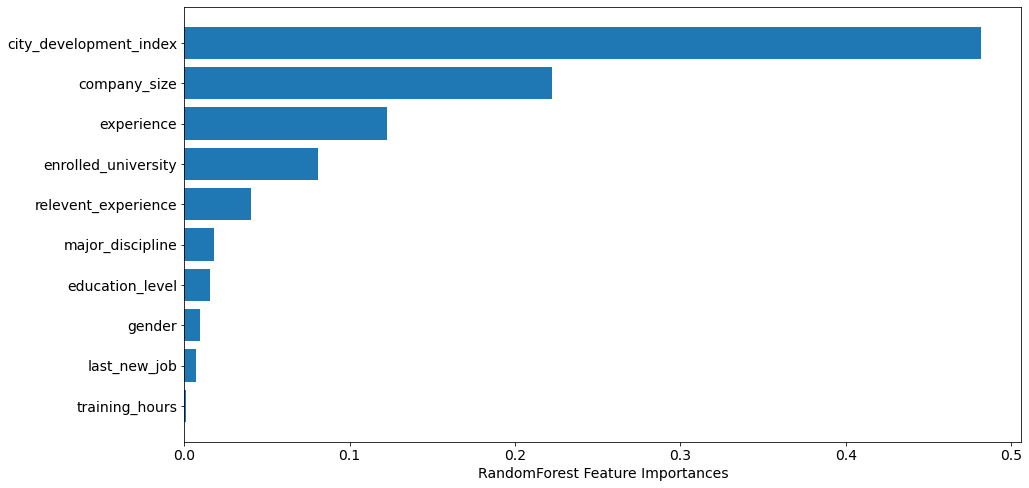

In [ ]:
# Ensemble
  # RandomForest 특성 중요도 파악 
import matplotlib.pyplot as plt 
from sklearn.inspection import permutation_importance

# 모델 설정
rnd_clf_f = RandomForestClassifier(n_estimators=5000, n_jobs=-1, max_leaf_nodes=250, max_depth=2)
rnd_clf_f.fit(X_train, y_train)

plt.rcParams.update({"figure.figsize": (15.0, 8.0)})
plt.rcParams.update({"font.size": 14})

# 시각화
sorted_idx = rnd_clf_f.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], rnd_clf_f.feature_importances_[sorted_idx])
plt.xlabel("RandomForest Feature Importances")

### ***MLP_Classifier***

In [ ]:
# MLP를 활용한 Classifier 

import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

print("tf version: ", tf.__version__)
print("keras version: ", keras.__version__)

tf version:  2.8.0
keras version:  2.8.0


StandardScaler()
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 10)                0         
                                                                 
 dense_7 (Dense)             (None, 300)               3300      
                                                                 
 dense_8 (Dense)             (None, 100)               30100     
                                                                 
 dense_9 (Dense)             (None, 1)                 101       
                                                                 
Total params: 33,501
Trainable params: 33,501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
599/599 [==============================] - 5s 7ms/step - loss: 0.5225 - accuracy: 0.7523 - val_loss: 0.5021 - val_accuracy: 0.7660
Epoch 2/300
599/599 [=

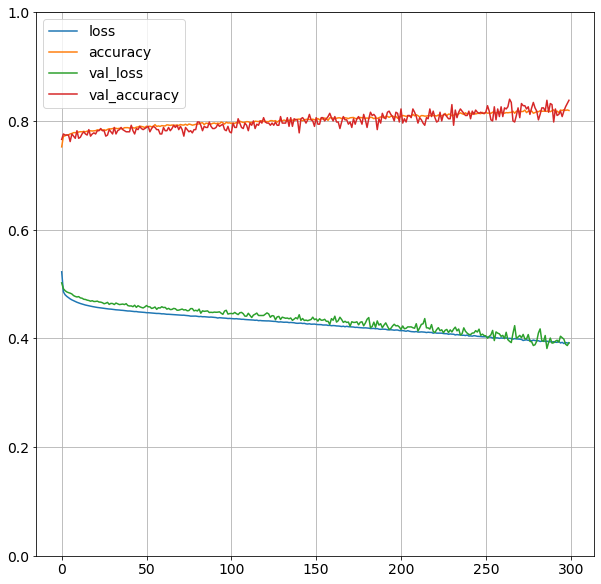

In [ ]:
# Basic MLP 작성

# Data Copy 
X_train_ann = X_train.copy()
y_train_ann = y_train.copy()

# MLP를 위한 Sclae 조정 
  # 이상치를 조정했으므로, StnadardScaler 활용 
from sklearn.preprocessing import StandardScaler 

standardScaler = StandardScaler()

print(standardScaler.fit(X_train_ann))
X_train_std = standardScaler.transform(X_train_ann)
X_train_std
X_valid_std = X_train_std[-500:]

# 기본적인 Sequential 모델 작성
  # 입력층 1, 은닉층 3, 출력층 (Logistic 이진분류)
mlp_clf = keras.models.Sequential()
mlp_clf.add(keras.layers.Flatten(input_shape=(10,)))
mlp_clf.add(keras.layers.Dense(300, activation="relu"))
mlp_clf.add(keras.layers.Dense(100, activation="relu"))
mlp_clf.add(keras.layers.Dense(1, activation="sigmoid"))

# MLP Callback
checkpoint_cb = keras.callbacks.ModelCheckpoint("aSSIST_Thesis_model", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)

# Model Summary
mlp_clf.summary()

# Model Complie
  # 손실함수, 경사하강법, Accuracy 지정
mlp_clf.compile(loss="binary_crossentropy", optimizer="sgd", metrics=["accuracy"])

# Model Fitting
mlp_clf_history = mlp_clf.fit(X_train_std, y_train, epochs=300, validation_data=(X_valid_std, y_valid), callbacks=[checkpoint_cb, early_stopping_cb])

# Accuracy measurement
mlp_clf_history.history

# mlp_clf Loss, Accuracy check
pd.DataFrame(mlp_clf_history.history).plot(figsize=(10,10))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

Epoch 1/300


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


599/599 [==============================] - 3s 4ms/step - loss: nan - accuracy: 0.7491 - val_loss: nan - val_accuracy: 0.7440
Epoch 2/300
599/599 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.7507 - val_loss: nan - val_accuracy: 0.7440
Epoch 3/300
599/599 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.7507 - val_loss: nan - val_accuracy: 0.7440
Epoch 4/300
599/599 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.7507 - val_loss: nan - val_accuracy: 0.7440
Epoch 5/300
599/599 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.7507 - val_loss: nan - val_accuracy: 0.7440
Epoch 6/300
599/599 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.7507 - val_loss: nan - val_accuracy: 0.7440
Epoch 7/300
599/599 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.7507 - val_loss: nan - val_accuracy: 0.7440
Epoch 8/300
599/599 [==============================] 

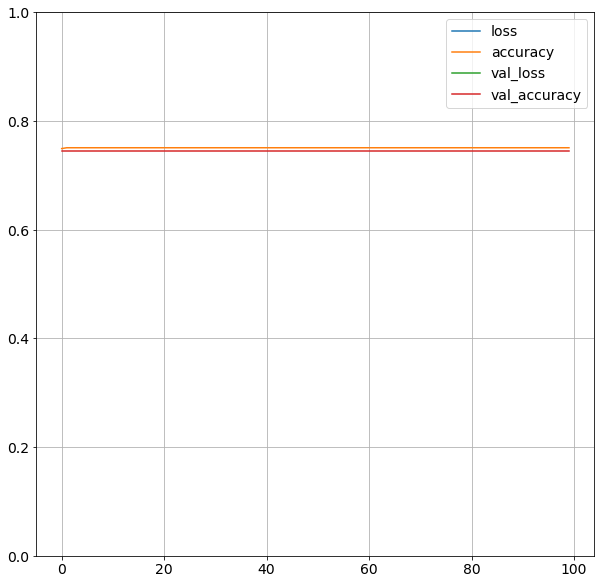

In [ ]:
# Sequential API를 활용한 분류 accuracy 향상 
  # 입력층을 분류하여 Wide와 Deep으로 다르게 학습 후 비교

# Train_set 분할 
X_train_std_A, X_train_std_B = X_train_std[:,:6], X_train_std[:,6:]
X_valid_std_A, X_valid_std_B = X_valid_std[:,:6], X_valid_std[:,6:]

# 입력층 2개 분할 모델 
input_a = keras.layers.Input(shape=(6,), name="wide_input")
input_b = keras.layers.Input(shape=(4,), name="deep_input")
hidden1 = keras.layers.Dense(300, activation="relu")(input_b)
hidden2 = keras.layers.Dense(100, activation="relu")(hidden1)
hidden3 = keras.layers.Dense(30, activation="relu")(hidden2)
hidden_a = keras.layers.Dense(200, activation="relu")(input_a)
concat = keras.layers.concatenate([hidden_a, hidden3])
output = keras.layers.Dense(1, name="output", activation="sigmoid")(concat)
mlp_clf_seq = keras.Model(inputs=[input_a, input_b], outputs=[output])

# model compile
mlp_clf_seq.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1e03), metrics="accuracy")

# model fitting
mlp_clf_seq = mlp_clf_seq.fit((X_train_std_A, X_train_std_B), y_train, epochs=300, validation_data=((X_valid_std_A, X_valid_std_B), y_valid), callbacks=[checkpoint_cb, early_stopping_cb])

# mlp_clf Loss, Accuracy check
pd.DataFrame(mlp_clf_seq.history).plot(figsize=(10,10))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

StandardScaler()
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 10)                0         
                                                                 
 dense_61 (Dense)            (None, 30)                330       
                                                                 
 dense_62 (Dense)            (None, 20)                620       
                                                                 
 dense_63 (Dense)            (None, 10)                210       
                                                                 
 dense_64 (Dense)            (None, 1)                 11        
                                                                 
Total params: 1,171
Trainable params: 1,171
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3000


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


599/599 [==============================] - 4s 6ms/step - loss: 0.5369 - accuracy: 0.7415 - val_loss: 0.5072 - val_accuracy: 0.7800
Epoch 2/3000
599/599 [==============================] - 2s 3ms/step - loss: 0.4929 - accuracy: 0.7680 - val_loss: 0.4983 - val_accuracy: 0.7880
Epoch 3/3000
599/599 [==============================] - 2s 4ms/step - loss: 0.4879 - accuracy: 0.7700 - val_loss: 0.4934 - val_accuracy: 0.7840
Epoch 4/3000
599/599 [==============================] - 2s 3ms/step - loss: 0.4849 - accuracy: 0.7713 - val_loss: 0.4895 - val_accuracy: 0.7760
Epoch 5/3000
599/599 [==============================] - 2s 3ms/step - loss: 0.4825 - accuracy: 0.7714 - val_loss: 0.4853 - val_accuracy: 0.7860
Epoch 6/3000
599/599 [==============================] - 2s 3ms/step - loss: 0.4804 - accuracy: 0.7721 - val_loss: 0.4845 - val_accuracy: 0.7700
Epoch 7/3000
599/599 [==============================] - 2s 3ms/step - loss: 0.4787 - accuracy: 0.7735 - val_loss: 0.4798 - val_accuracy: 0.7820
Epoch

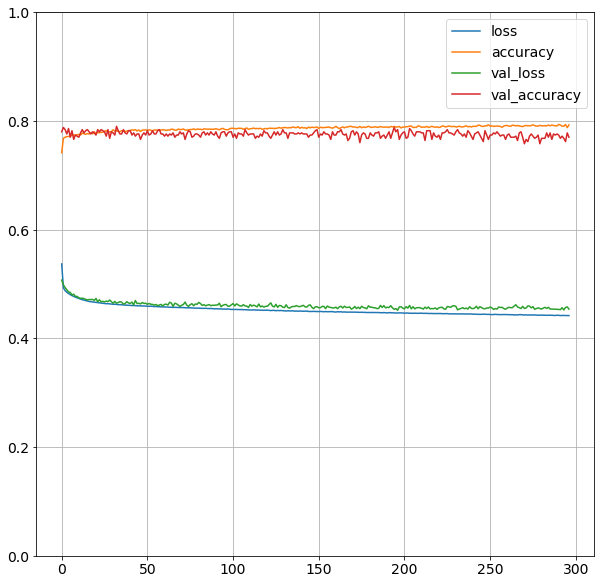

In [ ]:
# MLP 모델 하이퍼파라미터 조정 및 Accuracy 극대화 

# Data Copy 
X_train_best = X_train.copy()
y_train_best = y_train.copy()

# MLP를 위한 Sclae 조정 
  # 이상치를 조정했으므로, StnadardScaler 활용 
from sklearn.preprocessing import StandardScaler 

standardScaler = StandardScaler()

print(standardScaler.fit(X_train_best))
X_train_std = standardScaler.transform(X_train_best)
X_valid_std = X_train_std[-500:]

# 기본적인 Sequential 모델 작성
  # 입력층 1, 은닉층 3, 출력층 (Logistic 이진분류)
  # He 초기화 설정 (fan_out 기반)
  # activation 변경 
  # 그라디언트 클리핑 설정 
  # 고속 옵티마이저 설정 
# mlp_clf = keras.models.Sequential()
# mlp_clf.add(keras.layers.Flatten(input_shape=(10,)))
# mlp_clf.add(keras.layers.Dense(30, activation="elu"), kernel_initializer="he_normal")
# mlp_clf.add(keras.layers.Dense(20, activation="elu"), kernel_initializer="he_normal")
# mlp_clf.add(keras.layers.Dense(10, activation="elu"), kernel_initializer="he_normal")
# mlp_clf.add(keras.layers.Dense(1, activation="sigmoid"))

mlp_clf = keras.models.Sequential([
                                   keras.layers.Flatten(input_shape=(10,)),
                                   keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal"),
                                   keras.layers.Dense(20, activation="elu", kernel_initializer="he_normal"),
                                   keras.layers.Dense(10, activation="elu", kernel_initializer="he_normal"),
                                   keras.layers.Dense(1, activation="sigmoid")
])

# MLP Callback
checkpoint_cb = keras.callbacks.ModelCheckpoint("aSSIST_Thesis_model", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)

# Model Summary
mlp_clf.summary()

# Model Complie
  # 손실함수, 경사하강법, Accuracy 지정
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)
mlp_clf.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Model Fitting
mlp_clf_history = mlp_clf.fit(X_train_std, y_train, epochs=3000, validation_data=(X_valid_std, y_valid), callbacks=[checkpoint_cb, early_stopping_cb])

# Accuracy measurement
mlp_clf_history.history

# mlp_clf Loss, Accuracy check
pd.DataFrame(mlp_clf_history.history).plot(figsize=(10,10))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()